#Deep Generative Filter for Motion Deblurring



In [1]:
import numpy as np
import os
import math
import h5py
from tqdm import tqdm
from PIL import Image
import glob as gb
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
os.chdir('/content/drive/My Drive/IVPMiniProject/') 

Mounted at /content/drive/


In [3]:
np.random.seed(42)

## Data Utils

In [4]:
def format_image(image_path, size):
  image = Image.open(image_path)
  # slice image into full and blur images
  image_full = image.crop((0, 0, image.size[0] / 2, image.size[1]))
  # Note: full image in left, the blur image in right
  image_blur = image.crop((image.size[0] / 2, 0, image.size[0], image.size[1]))
  image_full = image_full.resize((size, size), Image.ANTIALIAS)
  image_blur = image_blur.resize((size, size), Image.ANTIALIAS)
  return np.array(image_full), np.array(image_blur)

In [5]:
def build_hdf5(jpeg_dir, size=256):
  # put data in HDF5
  hdf5_file = os.path.join('./data', 'data.h5')
  with h5py.File(hdf5_file, 'w') as f:
    for data_type in tqdm(['train', 'val', 'test']):
      data_path = jpeg_dir + '/'+data_type +'/*.jpg' 
      images_path = gb.glob(data_path)
      data_full = []
      data_blur = []
      for image_path in images_path:
        image_full, image_blur = format_image(image_path, size)
        data_full.append(image_full)
        data_blur.append(image_blur)
      f.create_dataset('%s_data_full' % data_type, data=data_full)
      f.create_dataset('%s_data_blur' % data_type, data=data_blur)

In [6]:
def load_data(data_type):
  with h5py.File('data/data.h5', 'r') as f:
    data_full = f['%s_data_full' % data_type][:].astype(np.float32)
    data_full = data_full/127.5 - 1
    data_blur = f['%s_data_blur' % data_type][:].astype(np.float32)
    data_blur = data_blur/127.5 - 1
    data_blur = np.array(data_blur)
    data_full = np.array(data_full)
    data_blur = np.transpose(data_blur,(0,3,1,2))
    data_full = np.transpose(data_full,(0,3,1,2))
    return data_blur, data_full

In [7]:
def generate_image(full, blur, generated, path, epoch=None, index=None):
  blur = np.transpose(blur,(0,2,3,1))
  full = np.transpose(full,(0,2,3,1))
  generated = np.transpose(generated,(0,2,3,1))
  full = full * 127.5 + 127.5
  blur = blur * 127.5 + 127.5
  generated = generated * 127.5 + 127.5
  for i in range(generated.shape[0]):
    image_full = full[i, :, :, :]
    image_blur = blur[i, :, :, :]
    image_generated = generated[i, :, :, :]
    image = np.concatenate((image_full, image_blur, image_generated), axis=1)
    if (epoch is not None) and (index is not None):
      Image.fromarray(image.astype(np.uint8)).save(path + str(epoch + 1) + '_' + str(index + 1) + '.png')
    else:
      Image.fromarray(image.astype(np.uint8)).save(path + str(i) + '.png')

In [8]:
# build_hdf5('./data')

##Models

In [9]:
!pip install pytorch-model-summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,models
from torch.utils.data import DataLoader, TensorDataset
from pytorch_model_summary import summary

In [10]:
torch.manual_seed(42)

In [11]:
class netG(nn.Module):
  def __init__(self,nChannels=256,channel_rate=64,drop_rate=0.0,dilation=1):
    super(netG, self).__init__()
    self.channel_rate = channel_rate
    self.nChannels = nChannels
    self.drop_rate = drop_rate
    self.dilation = 1
    self.wh = nn.Parameter(torch.Tensor(4*self.channel_rate,3, 3, 3).normal_(0,0.0001))
    self.w11 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels,1, 1).normal_(0,0.0001))
    self.w21 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+1*self.channel_rate,  1, 1).normal_(0,0.0001)) 
    self.w31 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+2*self.channel_rate, 1, 1).normal_(0,0.0001))
    self.w41 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+3*self.channel_rate, 1, 1).normal_(0,0.0001))
    self.w51 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+4*self.channel_rate, 1, 1).normal_(0,0.0001))
    self.w61 = nn.Parameter(torch.Tensor(4*self.channel_rate, self.nChannels+5*self.channel_rate,1, 1).normal_(0,0.0001))
    self.w71 = nn.Parameter(torch.Tensor(4*self.channel_rate, self.nChannels+6*self.channel_rate,1, 1).normal_(0,0.0001))
    self.w81 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+7*self.channel_rate, 1, 1).normal_(0,0.0001))
    self.w91 = nn.Parameter(torch.Tensor(4*self.channel_rate,self.nChannels+8*self.channel_rate, 1, 1).normal_(0,0.0001))
    self.w101 = nn.Parameter(torch.Tensor(4*self.channel_rate, self.nChannels+9*self.channel_rate,1, 1).normal_(0,0.0001))
    self.w12 =  nn.Parameter(torch.Tensor(self.channel_rate,4*self.channel_rate,3,3).normal_(0,0.0001))
    self.w102 = self.w92 = self.w82 = self.w72 = self.w62 = self.w52 = self.w42 = self.w32 = self.w22 = self.w12
    self.wt = nn.Parameter(torch.Tensor(self.channel_rate,self.channel_rate, 1, 1).normal_(0,0.0001))
    self.wll1 = nn.Parameter(torch.Tensor(self.channel_rate,5*self.channel_rate,3,3).normal_(0,0.0001))
    self.wll2 = nn.Parameter(torch.Tensor(3,self.channel_rate,3,3).normal_(0,0.0001))
    self.wprelu = nn.Parameter(torch.Tensor(self.channel_rate).normal_(0,0.0001))
    
    self.rm11,self.rv11 = nn.Parameter(torch.zeros(self.nChannels),False),nn.Parameter(torch.ones(self.nChannels),False)
    self.rm21,self.rv21 = nn.Parameter(torch.zeros(self.nChannels+1*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+1*self.channel_rate),False)
    self.rm31,self.rv31 = nn.Parameter(torch.zeros(self.nChannels+2*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+2*self.channel_rate),False)
    self.rm41,self.rv41 = nn.Parameter(torch.zeros(self.nChannels+3*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+3*self.channel_rate),False)
    self.rm51,self.rv51 = nn.Parameter(torch.zeros(self.nChannels+4*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+4*self.channel_rate),False)
    self.rm61,self.rv61 = nn.Parameter(torch.zeros(self.nChannels+5*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+5*self.channel_rate),False)
    self.rm71,self.rv71 = nn.Parameter(torch.zeros(self.nChannels+6*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+6*self.channel_rate),False)
    self.rm81,self.rv81 = nn.Parameter(torch.zeros(self.nChannels+7*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+7*self.channel_rate),False)
    self.rm91,self.rv91 = nn.Parameter(torch.zeros(self.nChannels+8*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+8*self.channel_rate),False)
    self.rm101,self.rv101 = nn.Parameter(torch.zeros(self.nChannels+9*self.channel_rate),False),nn.Parameter(torch.ones(self.nChannels+9*self.channel_rate),False)
    self.rm102 = self.rm92 = self.rm82 = self.rm72 = self.rm62 = self.rm52 = self.rm42 = self.rm32 = self.rm22 = self.rm12 = nn.Parameter(torch.zeros(4*self.channel_rate),False)
    self.rv102 = self.rv92 = self.rv82 = self.rv72 = self.rv62 = self.rv52 = self.rv42 = self.rv32 = self.rv22 = self.rv12 = nn.Parameter(torch.ones(4*self.channel_rate),False) 
    self.rm103 = self.rm93 = self.rm83 = self.rm73 = self.rm63 = self.rm53 = self.rm43 = self.rm33 = self.rm23 = self.rm13 = nn.Parameter(torch.zeros(self.channel_rate),False)
    self.rv103 = self.rv93 = self.rv83 = self.rv73 = self.rv63 = self.rv53 = self.rv43 = self.rv33 = self.rv23 = self.rv13 = nn.Parameter(torch.ones(self.channel_rate),False) 
    self.rmt1,self.rvt1 = nn.Parameter(torch.zeros(self.channel_rate),False),nn.Parameter(torch.ones(self.channel_rate),False)
    self.rml1,self.rvl1 = nn.Parameter(torch.zeros(self.channel_rate),False),nn.Parameter(torch.ones(self.channel_rate),False)

  def forward(self,x):
    #head
    x = F.conv2d(x,self.wh,bias=None,dilation=1,padding=1)
    x1 = x
    #dense_block-1
    d = F.batch_norm(x,self.rm11,self.rv11,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w11,bias=None)
    d = F.batch_norm(d,self.rm12,self.rv12,training=True,momentum=0.9)
    d = F.conv2d(d,self.w12,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm13,self.rv13,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-2
    d = F.batch_norm(x,self.rm21,self.rv21,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w21,bias=None)
    d = F.batch_norm(d,self.rm22,self.rv22,training=True,momentum=0.9)
    d = F.conv2d(d,self.w22,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm23,self.rv23,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-3
    d = F.batch_norm(x,self.rm31,self.rv31,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w31,bias=None)
    d = F.batch_norm(d,self.rm32,self.rv32,training=True,momentum=0.9)
    d = F.conv2d(d, self.w32,bias=None,dilation=2,padding=2)
    d = F.batch_norm(d,self.rm33,self.rv33,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-4
    d = F.batch_norm(x,self.rm41,self.rv41,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w41,bias=None)
    d = F.batch_norm(d,self.rm42,self.rv42,training=True,momentum=0.9)
    d = F.conv2d(d,self.w42,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm43,self.rv43,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-5
    d = F.batch_norm(x,self.rm51, self.rv51, training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w51,bias=None)
    d = F.batch_norm(d,self.rm52,self.rv52, training=True,momentum=0.9)
    d = F.conv2d(d, self.w52, bias=None,dilation=3,padding=3)
    d = F.batch_norm(d,self.rm53, self.rv53 ,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-6
    d = F.batch_norm(x,self.rm61,self.rv61,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w61, bias=None)
    d = F.batch_norm(d,self.rm62, self.rv62,training=True,momentum=0.9)
    d = F.conv2d(d,self.w62, bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm63,self.rv63,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-7
    d = F.batch_norm(x,self.rm71, self.rv71, training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d, self.w71,bias=None)
    d = F.batch_norm(d,self.rm72,self.rv72,training=True,momentum=0.9)
    d = F.conv2d(d, self.w72,bias=None,dilation=2,padding=2)
    d = F.batch_norm(d,self.rm73,self.rv73,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)
    #dense_block-8
    d = F.batch_norm(x,self.rm81, self.rv81,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w81,bias=None)
    d = F.batch_norm(d,self.rm82, self.rv82,training=True,momentum=0.9)
    d = F.conv2d(d,self.w82,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm83, self.rv83,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)

    #dense_block-9
    d = F.batch_norm(x,self.rm91,self.rv91,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w91,bias=None)
    d = F.batch_norm(d,self.rm92,self.rv92,training=True,momentum=0.9)
    d = F.conv2d(d,self.w92,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm93,self.rv93,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
    
    x = torch.cat([x,d],1)

    #dense_block-10
    d = F.batch_norm(x,self.rm101,self.rv101,training=True,momentum=0.9)
    d = F.leaky_relu(d,0.2)
    d = F.conv2d(d,self.w101,bias=None)
    d = F.batch_norm(d,self.rm102,self.rv102,training=True,momentum=0.9)
    d = F.conv2d(d,self.w102,bias=None,dilation=1,padding=1)
    d = F.batch_norm(d,self.rm103,self.rv103,training=True,momentum=0.9)
    d = F.dropout2d(d,p=self.drop_rate)
   
    #tail
    x = F.leaky_relu(d,0.2)
    x = F.conv2d(x,self.wt,bias=None)
    x = F.batch_norm(x,self.rmt1,self.rvt1,training=True,momentum=0.9)
    x = F.dropout2d(x,p=self.drop_rate)

    x = torch.cat([x,x1],1)
    
    #last_layer
    x = F.conv2d(x,self.wll1,bias=None,dilation=1,padding=1)
    x = F.prelu(x,self.wprelu)
    x = F.conv2d(x,self.wll2,bias=None,dilation=1,padding=1)
    x = F.tanh(x)

    return x

In [12]:
class netD(nn.Module):
  def __init__(self,channel_rate=64,patch_size=64,image_size=256,device='cuda'):
    super(netD,self).__init__()
    self.channel_rate = channel_rate
    self.patch_size = patch_size
    self.image_size = image_size
    self.device = device
    self.conv1 = nn.Conv2d(3,self.channel_rate,3,2)
    self.conv2 = nn.Conv2d(self.channel_rate,2*self.channel_rate,3,2)
    self.conv3 = nn.Conv2d(2*self.channel_rate,3*self.channel_rate,3,2)
    self.conv4 = nn.Conv2d(3*self.channel_rate,4*self.channel_rate,3,2)
    self.bn1 = nn.BatchNorm2d(self.channel_rate)
    self.bn2 = nn.BatchNorm2d(2*self.channel_rate)
    self.bn3 = nn.BatchNorm2d(3*self.channel_rate)
    self.bn4 = nn.BatchNorm2d(4*self.channel_rate)
    self.dense1 = nn.Linear(4*self.channel_rate*3*3,1)
  
  def forward(self,x):
    list_row_idx = [(i * self.channel_rate, (i + 1) * self.channel_rate) for i in range(int(self.image_size/self.patch_size))]
    list_col_idx = [(i * self.channel_rate, (i + 1) * self.channel_rate) for i in range(int(self.image_size/self.patch_size))]

    list_patch = []
    for row_idx in list_row_idx:
      for col_idx in list_col_idx:
        x_patch = x[:, :, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1]]
        list_patch.append(x_patch)

    list_output=0.0
    for x in list_patch:
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.leaky_relu(x,0.2)
      x = self.conv2(x)
      x = self.bn2(x)
      x = F.leaky_relu(x,0.2)
      x = self.conv3(x)
      x = self.bn3(x)
      x = F.leaky_relu(x,0.2)
      x = self.conv4(x)
      x = self.bn4(x)
      x = F.leaky_relu(x,0.2)
      x = torch.flatten(x,1)
      x = self.dense1(x)
      x = F.sigmoid(x)
      list_output+=x
    output=list_output/len(list_patch)
    
    return output

In [13]:
class netD_on_G(nn.Module):
  def __init__(self,modelG,modelD,channel_rate=64,image_size=256,dropout=0.0):
    super(netD_on_G,self).__init__()
    self.channel_rate = channel_rate
    self.patch_size = self.channel_rate
    self.image_size = image_size
    self.dropout = dropout
    self.modelG = modelG
    self.modelD = modelD

  def forward(self,x):
    x = self.modelG(x)
    x = self.modelD(x)
    return x

##Losses

In [14]:
class VGGPerceptualLoss(nn.Module):
  def __init__(self, resize=True):
    super(VGGPerceptualLoss, self).__init__()
    blocks = []
    blocks.append(models.vgg16(pretrained=True).features[:4].eval())
    blocks.append(models.vgg16(pretrained=True).features[4:9].eval())
    blocks.append(models.vgg16(pretrained=True).features[9:16].eval())
    blocks.append(models.vgg16(pretrained=True).features[16:23].eval())
    for bl in blocks:
      for p in bl.parameters():
        p.requires_grad = False
        
    self.blocks = nn.ModuleList(blocks)
    self.transform = F.interpolate
    self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1,3,1,1))
    self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1,3,1,1))
    self.resize = resize

  def forward(self, input, target):
    if input.shape[1] != 3:
      input = input.repeat(1, 3, 1, 1)
      target = target.repeat(1, 3, 1, 1)
    input = (input-self.mean) / self.std
    target = (target-self.mean) / self.std
    if self.resize:
      input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
      target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
    loss = 0.0
    x = input
    y = target
    for block in self.blocks:
      x = block(x)
      y = block(y)
      loss += F.l1_loss(x, y)
    return loss

In [15]:
def generator_loss(input,target,K1=145,K2=170):
  per_loss = VGGPerceptualLoss().to('cuda')
  return K1*per_loss(input,target)+K2*F.l1_loss(input,target)

def adversarial_loss(y_pred):
  return -1*torch.log(y_pred)

##Train 

In [16]:
data_train = TensorDataset(torch.from_numpy(load_data('train')[0]),torch.from_numpy(load_data('train')[1]))
# data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(20)])
train_loader = DataLoader(data_train,batch_size=1,shuffle=True,num_workers=2)

In [ ]:
def fit(modelG,modelD,modelD_on_G,train_loader,epochs,device):
  optimizerG = optim.Adam(modelG.parameters(),lr=0.0002, betas=(0.9, 0.999))
  optimizerD = optim.Adam(modelD.parameters(),lr=0.0002, betas=(0.9, 0.999))
  optimizerD_on_G = optim.SGD(modelD_on_G.parameters(),lr=0.0002,momentum=0.9,nesterov=True, weight_decay=1e-6)
  criteriaD = nn.BCELoss()
  G_losses,D_losses,D_on_G_losses=[],[],[]
  #criteriaG : generator_loss
  #cireriaG_on_D: adversarial_loss
  for epoch in range(epochs):
    for i,data in enumerate(train_loader):
      image_blur, image_full = data[0].to(device),data[1].to(device)
      ############################
      # (1) Update D network
      ###########################
      ## Train with all-real batch
      optimizerD.zero_grad()
      pred = modelD(image_full).view(-1)
      b_size = image_blur.size(0)
      y = torch.full((b_size,), 1.0, device=device)  
      errD_real = criteriaD(pred,y)
      errD_real.backward()
      D_x = pred.mean().item()

      ## Train with all-fake batch
      fake_clear = modelG(image_blur)
      y.fill_(0)
      pred = modelD(fake_clear.detach()).view(-1)
      errD_fake = criteriaD(pred,y)
      errD_fake.backward()
      D_G_z1 = pred.mean().item()
      errD = errD_real + errD_fake

      optimizerD.step()

      ############################
      # (2) Update D_on_G network
      ###########################
      optimizerD_on_G.zero_grad()
      pred = modelD(modelG(image_blur).detach()).view(-1)
      adv_loss = adversarial_loss(pred)
      adv_loss.backward()
      D_G_z2 = pred.mean().item()
      optimizerD_on_G.step()

      ############################
      # (3) Update G network
      ###########################
      optimizerG.zero_grad()
      pred = modelG(image_blur)
      # Calculate G's loss based on this output
      errG = generator_loss(pred,image_full)
      # Calculate gradients for G
      errG.backward()
      G_z = pred.mean().item()
      # Updating G
      optimizerG.step()

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss D_on_G: %.4f' % (epoch, epochs, i, len(train_loader), 
          errD.item(), errG.item(), adv_loss.item()))
      
      # Saving Losses of each iter
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      D_on_G_losses.append(adv_loss.item())

  return G_losses,D_losses,D_on_G_losses

In [ ]:
epochs=10
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
modelG = netG().to(device)
modelD = netD().to(device)
modelD_on_G = netD_on_G(modelG,modelD).to(device)

In [ ]:
modelG.load_state_dict(torch.load('./models/30 epochs/modelG.pt'))
modelD.load_state_dict(torch.load('./models/30 epochs/modelD.pt'))
modelD_on_G.load_state_dict(torch.load('./models/30 epochs/modelD_on_G.pt'))

<All keys matched successfully>

In [ ]:
G_losses,D_losses,D_on_G_losses = fit(modelG,modelD,modelD_on_G,train_loader,epochs,device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



[0/10][0/297]	Loss_D: 1.3932	Loss_G: 697.2098	Loss D_on_G: 0.4699
[0/10][50/297]	Loss_D: 0.6027	Loss_G: 488.9244	Loss D_on_G: 0.9314
[0/10][100/297]	Loss_D: 0.7163	Loss_G: 357.1435	Loss D_on_G: 1.2984
[0/10][150/297]	Loss_D: 0.4745	Loss_G: 477.2982	Loss D_on_G: 1.5510
[0/10][200/297]	Loss_D: 0.5251	Loss_G: 789.7498	Loss D_on_G: 0.9711
[0/10][250/297]	Loss_D: 0.6104	Loss_G: 964.8044	Loss D_on_G: 0.8153
[1/10][0/297]	Loss_D: 0.8524	Loss_G: 598.0364	Loss D_on_G: 0.6950
[1/10][50/297]	Loss_D: 0.4109	Loss_G: 385.8402	Loss D_on_G: 1.2827
[1/10][100/297]	Loss_D: 0.5244	Loss_G: 339.3220	Loss D_on_G: 1.3213
[1/10][150/297]	Loss_D: 0.7016	Loss_G: 553.8557	Loss D_on_G: 0.8465
[1/10][200/297]	Loss_D: 0.7233	Loss_G: 470.7755	Loss D_on_G: 0.9785
[1/10][250/297]	Loss_D: 0.9729	Loss_G: 388.7202	Loss D_on_G: 0.5750
[2/10][0/297]	Loss_D: 0.9352	Loss_G: 393.6227	Loss D_on_G: 0.7448
[2/10][50/297]	Loss_D: 1.1978	Loss_G: 600.5901	Loss D_on_G: 0.5793
[2/10][100/297]	Loss_D: 0.8546	Loss_G: 277.6605	Loss D_o

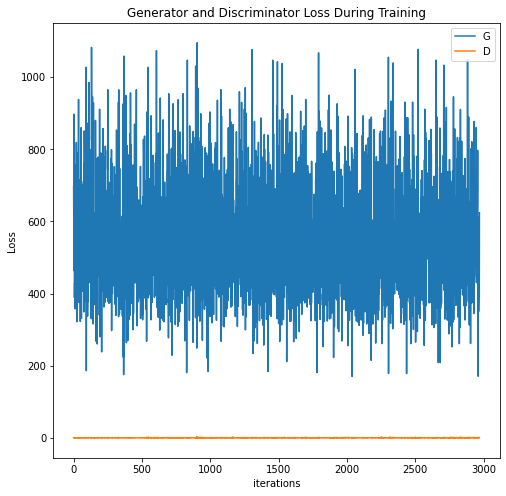

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(modelG.state_dict(),'./modelG.pt')
torch.save(modelD.state_dict(),'./modelD.pt')
torch.save(modelD_on_G.state_dict(),'./modelD_on_G.pt')

##Testing

In [14]:
data_test = TensorDataset(torch.from_numpy(load_data('test')[0]),torch.from_numpy(load_data('test')[1]))
test_loader = DataLoader(data_test,batch_size=1,shuffle=True,num_workers=2)

In [15]:
def test(modelG,test_loader):
  avg_psnr=0
  for i,data in enumerate(test_loader):
    image_blur, image_full = data[0].to(device),data[1].to(device)
    clear_image = modelG(image_blur)
    generate_image(image_full.cpu().detach().numpy(), image_blur.cpu().detach().numpy(), clear_image.detach().cpu().numpy(), './results/',0,i)
    mse = np.mean((image_full.cpu().detach().numpy()-clear_image.cpu().detach().numpy())**2)
    if mse==0:
      psnr=100
    else:
      psnr=20*math.log10(255/math.sqrt(mse))
    avg_psnr+=psnr
    if i%5==0:
      print('Completed: %d\tpsnr(dB): %.4f'%(i,psnr))
  print("Avg. PSNR(dB): %.4f"%(avg_psnr/len(test_loader)))

In [16]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
modelG = netG().to(device)
modelD = netD().to(device)
modelD_on_G = netD_on_G(modelG,modelD).to(device)

modelG.load_state_dict(torch.load('./models/40 epochs/modelG.pt'))
modelD.load_state_dict(torch.load('./models/40 epochs/modelD.pt'))
modelD_on_G.load_state_dict(torch.load('./models/40 epochs/modelD_on_G.pt'))

modelG.eval()
modelD.eval()
modelD_on_G.eval()

netD_on_G(
  (modelG): netG()
  (modelD): netD(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(128, 192, kernel_size=(3, 3), stride=(2, 2))
    (conv4): Conv2d(192, 256, kernel_size=(3, 3), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense1): Linear(in_features=2304, out_features=1, bias=True)
  )
)

In [17]:
test(modelG,test_loader)

Completed: 0	psnr(dB): 68.9100
Completed: 5	psnr(dB): 60.7635
Completed: 10	psnr(dB): 63.4994
Completed: 15	psnr(dB): 66.1220
Completed: 20	psnr(dB): 67.9491
Completed: 25	psnr(dB): 66.9991
Completed: 30	psnr(dB): 66.2768
Completed: 35	psnr(dB): 63.9271
Completed: 40	psnr(dB): 65.2654
Completed: 45	psnr(dB): 63.7343
Completed: 50	psnr(dB): 63.6134
Completed: 55	psnr(dB): 67.3261
Completed: 60	psnr(dB): 66.4330
Completed: 65	psnr(dB): 67.0633
Completed: 70	psnr(dB): 64.2006
Completed: 75	psnr(dB): 67.5074
Completed: 80	psnr(dB): 64.3567
Completed: 85	psnr(dB): 64.6001
Completed: 90	psnr(dB): 72.1574
Completed: 95	psnr(dB): 64.4306
Completed: 100	psnr(dB): 68.8872
Completed: 105	psnr(dB): 65.3630
Completed: 110	psnr(dB): 64.4332
Avg. PSNR(dB): 66.4959
